# Week 5 Exercise

# Setup

In [5]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import utils

# Exercise

1. Rotate image by 45 degrees without cropping the sides of the image. (Hint: There are 2 strategies to tackle these problems). Use _"lena.jfif"_ as the input image.
    - Use external libraries `imutils`.  
    - Modify the transformation matrix.

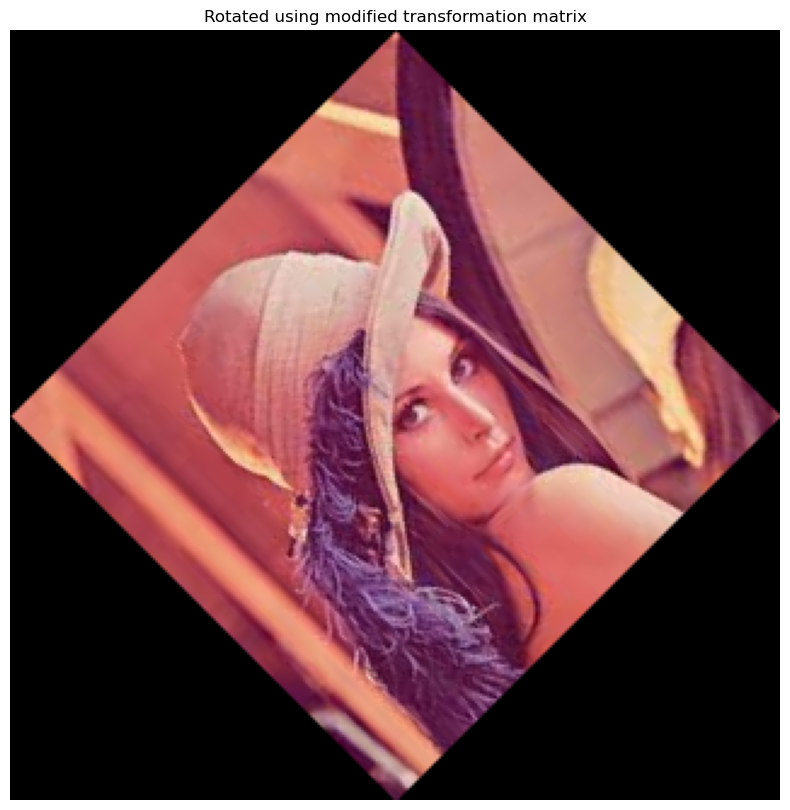

In [15]:
# Load the image
image_path = 'w5_Activity\Photo\images\lena.jfif'
image = cv2.imread(image_path)

# Check if the image was loaded successfully
if image is None:
    print("Failed to load the image. Please check the file path.")
else:
    # Get image dimensions
    (h, w) = image.shape[:2]
    (cX, cY) = (w // 2, h // 2)

    # Compute the rotation matrix
    M = cv2.getRotationMatrix2D((cX, cY), 45, 1.0)
    # Compute the new bounding dimensions of the image
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))

    # Adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY

    # Perform the actual rotation and return the image
    rotated_matrix = cv2.warpAffine(image, M, (nW, nH))

    # Plotting the results
    plt.figure(figsize=(10, 10))
    plt.title('Rotated using modified transformation matrix')
    plt.imshow(cv2.cvtColor(rotated_matrix, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

2. Use the images with titles: _"flower.jfif"_ and _"native-bee.png"_. I want to put flower above an image. If I add two images, it will change color. If I blend it, I get a transparent effect. But I want it to be opaque. If it was a rectangular region, we could use the ROI as we did in the previous section. But flower is not a rectangular region. This is where bitwise operations, like AND, OR, NOT and XOR really come in handy. The associated functions are `cv.bitwise_and()`, `cv.bitwise_or()` and `cv.bitwise_not()`. You need to use `cv.threshold` function to segment the flower. Please refer to [online documentation](https://docs.opencv.org/4.x/d0/d86/tutorial_py_image_arithmetics.html) for more info. The result should resemble the following:  
![bee and flowers](img_embed/activity3.PNG "bee_flower")

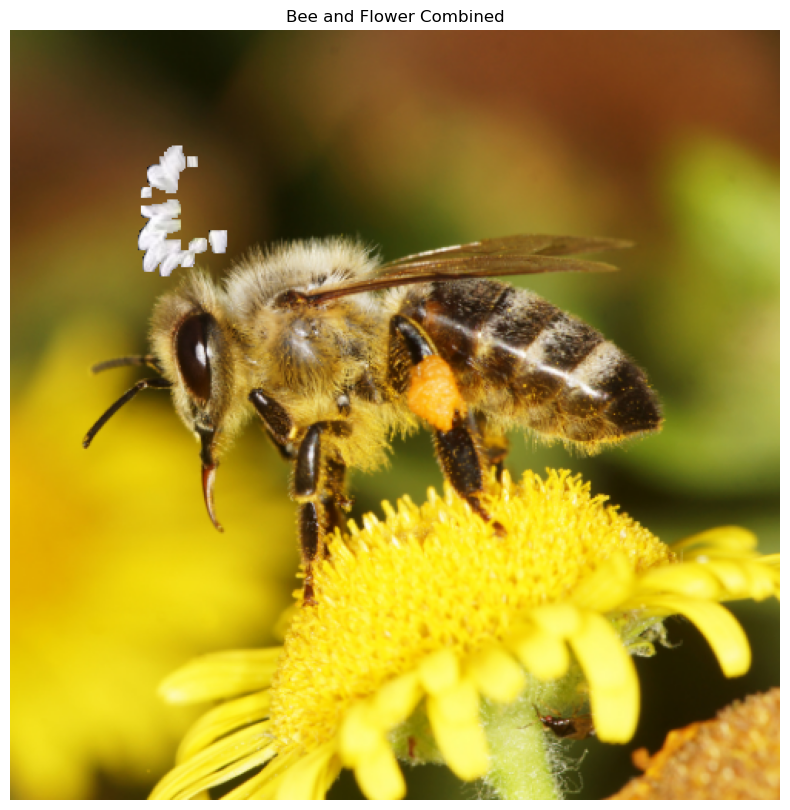

In [29]:
# Load the images
flower_path = 'w5_Activity/Photo/images/flower.jfif'
bee_path = 'w5_Activity/Photo/images/native-bee.png'

flower = cv2.imread(flower_path)
bee = cv2.imread(bee_path)

# Check if the images were loaded successfully
if flower is None or bee is None:
    print("Failed to load one or both images. Please check the file paths.")
else:
    # Resize the flower image to fit onto the bee image
    flower_resized = cv2.resize(flower, (bee.shape[1] // 2, bee.shape[0] // 2))

    # Convert flower image to HSV color space
    flower_hsv = cv2.cvtColor(flower_resized, cv2.COLOR_BGR2HSV)

    # Define the color range for masking (white flower on a black background)
    lower_white = np.array([0, 0, 200], dtype=np.uint8)
    upper_white = np.array([255, 55, 255], dtype=np.uint8)
    mask = cv2.inRange(flower_hsv, lower_white, upper_white)

    # Refine the mask using morphological operations
    kernel = np.ones((3,3), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=2)
    mask = cv2.morphologyEx(mask, cv2.MORPH_DILATE, kernel, iterations=1)

    # Invert the mask
    mask_inv = cv2.bitwise_not(mask)

    # Get the region of interest on the bee image
    rows, cols, _ = flower_resized.shape
    roi = bee[0:rows, 0:cols]

    # Black-out the area of flower in the bee image
    bee_bg = cv2.bitwise_and(roi, roi, mask=mask_inv)

    # Take only the region of flower from the flower image
    flower_fg = cv2.bitwise_and(flower_resized, flower_resized, mask=mask)

    # Put the flower in the bee image and modify the main image
    combined = cv2.add(bee_bg, flower_fg)
    bee[0:rows, 0:cols] = combined

    # Display the result
    plt.figure(figsize=(10, 10))
    plt.title('Bee and Flower Combined')
    plt.imshow(cv2.cvtColor(bee, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

3. Write a function that randomly crop the central region of an image. The method signature should be as shown in the following:
```
random_center_crop(image, min_crop_ratio, max_crop_ratio)
```

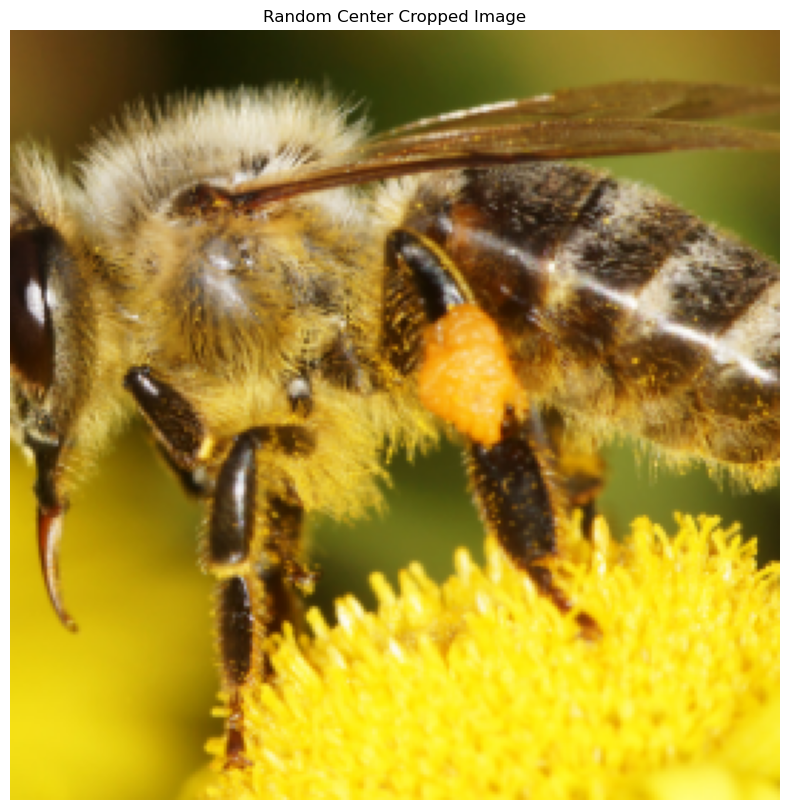

In [36]:
import random

def random_center_crop(image, min_crop_ratio, max_crop_ratio):
    """
    Randomly crops the central region of the image.

    Parameters:
    image (numpy.ndarray): The input image.
    min_crop_ratio (float): The minimum crop ratio.
    max_crop_ratio (float): The maximum crop ratio.

    Returns:
    numpy.ndarray: The cropped image.
    """
    height, width = image.shape[:2]
    
    # Ensure crop ratios are within valid range
    min_crop_ratio = max(0, min(min_crop_ratio, 1))
    max_crop_ratio = max(0, min(max_crop_ratio, 1))
    
    # Generate random crop ratio within the specified range
    crop_ratio = random.uniform(min_crop_ratio, max_crop_ratio)
    
    # Compute the dimensions of the cropped region
    crop_height = int(height * crop_ratio)
    crop_width = int(width * crop_ratio)
    
    # Compute the top-left corner of the cropped region to center the crop
    start_y = (height - crop_height) // 2
    start_x = (width - crop_width) // 2
    
    # Crop the image
    cropped_image = image[start_y:start_y + crop_height, start_x:start_x + crop_width]
    
    return cropped_image

image_path = 'w5_Activity/Photo/images/native-bee.png'
image = cv2.imread(image_path)

if image is not None:
    cropped_image = random_center_crop(image, 0.5, 0.6)
    
    # Display the result
    plt.figure(figsize=(10, 10))
    plt.title('Random Center Cropped Image')
    plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()
else:
    print("Failed to load the image. Please check the file path.")


4. Aside from Gaussian noise, name another common type of noise. Write the code to demonstrate how the noise can be included in an image.

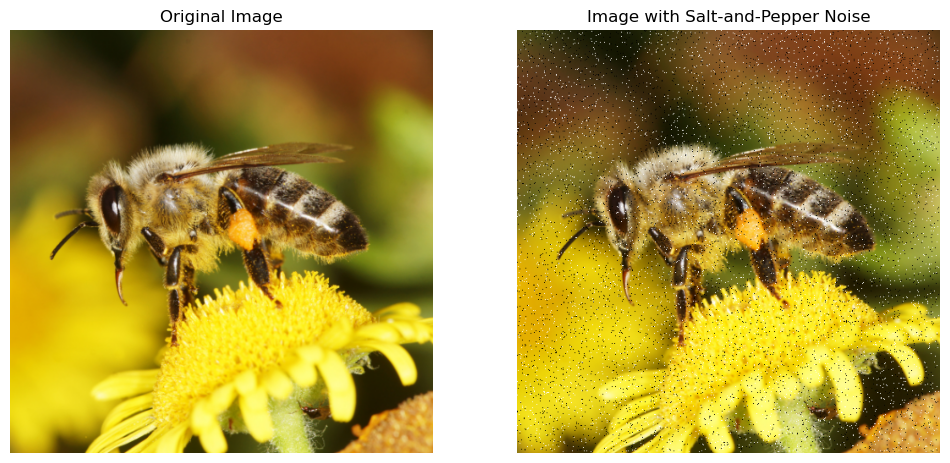

In [37]:
def add_salt_and_pepper_noise(image, salt_prob, pepper_prob):
    """
    Add salt-and-pepper noise to an image.

    Parameters:
    image (numpy.ndarray): The input image.
    salt_prob (float): Probability of salt noise.
    pepper_prob (float): Probability of pepper noise.

    Returns:
    numpy.ndarray: The noisy image.
    """
    noisy_image = image.copy()
    total_pixels = image.size // image.shape[2]  # Total number of pixels

    # Add salt noise
    num_salt = int(total_pixels * salt_prob)
    salt_coords = [np.random.randint(0, i - 1, num_salt) for i in image.shape]
    noisy_image[salt_coords[0], salt_coords[1], :] = 255

    # Add pepper noise
    num_pepper = int(total_pixels * pepper_prob)
    pepper_coords = [np.random.randint(0, i - 1, num_pepper) for i in image.shape]
    noisy_image[pepper_coords[0], pepper_coords[1], :] = 0

    return noisy_image

# Load the image
image_path = 'w5_Activity/Photo/images/native-bee.png'
image = cv2.imread(image_path)

if image is not None:
    # Add salt-and-pepper noise to the image
    salt_prob = 0.02  # Probability of salt noise
    pepper_prob = 0.02  # Probability of pepper noise
    noisy_image = add_salt_and_pepper_noise(image, salt_prob, pepper_prob)
    
    # Display the original and noisy images
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title('Image with Salt-and-Pepper Noise')
    plt.imshow(cv2.cvtColor(noisy_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.show()
else:
    print("Failed to load the image. Please check the file path.")